In [1]:
path_to_db = '/Users/naziaignatenko/Public/PRACTICUM_YANDEX/Projects/diplom/data/ds-plus-final.db'

In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine

path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import phik
from phik.report import plot_correlation_matrix


In [4]:
RANDOM_STATE = 160225

# 1. Загрузка таблиц

In [5]:
# Инициация связи с SQLite базой данных
conn = sqlite3.connect(path_to_db)

# Получаем список всех таблиц, присутствующих в базе данных
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Печатаем названия таблиц
print("Tables in the database:")
print(tables)

# Загружаем каждую таблицу Pandas DataFrame
data_dict = {}
for table in tables['name']:
    data_dict[table] = pd.read_sql(f"SELECT * FROM {table}", conn)

# Завершение связи
conn.close()

Tables in the database:
              name
0         data_arc
1        data_bulk
2   data_bulk_time
3   data_wire_time
4         contract
5         personal
6            phone
7         internet
8         data_gas
9        data_temp
10       data_wire


In [6]:
print(data_dict.keys())

dict_keys(['data_arc', 'data_bulk', 'data_bulk_time', 'data_wire_time', 'contract', 'personal', 'phone', 'internet', 'data_gas', 'data_temp', 'data_wire'])


#### База данных содержит таблицы двух проектов. Выберем только те таблицы, которые относятся к пректу "Телеком"

# 2. Проведение исследовательского анализа и предобработка данных

## Анализ исходных данных

In [7]:
contract_df = data_dict['contract'] 
contract_df.head(5) 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [8]:
contract_df = contract_df.rename(columns= {'customerID': 'CustomerID'})

In [9]:
contract_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [10]:
personal_df = data_dict['personal']  
personal_df.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
personal_df = personal_df.rename(columns = {'customerID': 'CustomerID', 'gender': 'Gender'})

In [12]:
phone_df = data_dict['phone']  
phone_df.head() 

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [13]:
phone_df = phone_df.rename(columns = {'CustomerId': 'CustomerID'})

In [14]:
internet_df = data_dict['internet']  
internet_df.head() 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
internet_df = internet_df.rename(columns = {'customerID': 'CustomerID'})

## Вывод:
1. Присутствуют все заявленные таблицы
2. Таблицы содержат данные
3. Таблицы загружены в формате pandas DataFrame

### Исследовательский анализ данных и обработка аномалий в каждом датафрейме

#### Датафрейм contract_df

In [16]:
contract_df.sample(5) 

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4267,1227-UDMZR,2014-02-01,No,Two year,Yes,Bank transfer (automatic),91.15,6956.57
2037,8309-IEYJD,2020-01-01,No,Month-to-month,Yes,Mailed check,70.6,70.6
4684,6305-YLBMM,2014-01-01,2017-09-01,One year,Yes,Bank transfer (automatic),104.05,5036.02
1960,5846-QFDFI,2017-05-01,No,Month-to-month,No,Credit card (automatic),88.6,3069.99
2866,7517-LDMPS,2019-02-01,No,Month-to-month,Yes,Electronic check,84.6,1015.2


In [17]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [18]:
contract_df["EndDate"] = contract_df["EndDate"].replace("No", pd.NaT) 
contract_df["TotalCharges"] = contract_df["TotalCharges"].replace(" ", "0") 
contract_df = contract_df.astype({
    "MonthlyCharges": "float",
    "TotalCharges": "float",
    "BeginDate": "datetime64[ns]",
    "EndDate": "datetime64[ns]"
})

In [19]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Cтолбец EndDate имеет очень много незаполненных строк (действующий договор), в остальных столбцах пропуски отсутствуют

In [20]:
contract_df.describe()

,BeginDate,EndDate,MonthlyCharges,TotalCharges
count,7043,1101,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2115.312885
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,436.750000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1343.350000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3236.690000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000
std,NaN,NaN,30.090047,2112.742814


In [21]:
contract_df.shape

(7043, 8)

##### Проверка наличия дубликатов

In [22]:
contract_df.duplicated().sum()

np.int64(0)

In [23]:
contract_df.duplicated(subset=["CustomerID"]).sum()

np.int64(0)

Дубликатов нет

In [24]:
# Вывод уникальных значений для столбцов 'Type' 'PaperlessBilling' 'PaymentMethod'
for column in contract_df.columns[3:6]:
    print(f"Уникальные значения в стобце {column}:")
    print(contract_df[column].unique())
    print()

Уникальные значения в стобце Type:
['Month-to-month' 'One year' 'Two year']

Уникальные значения в стобце PaperlessBilling:
['Yes' 'No']

Уникальные значения в стобце PaymentMethod:
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']



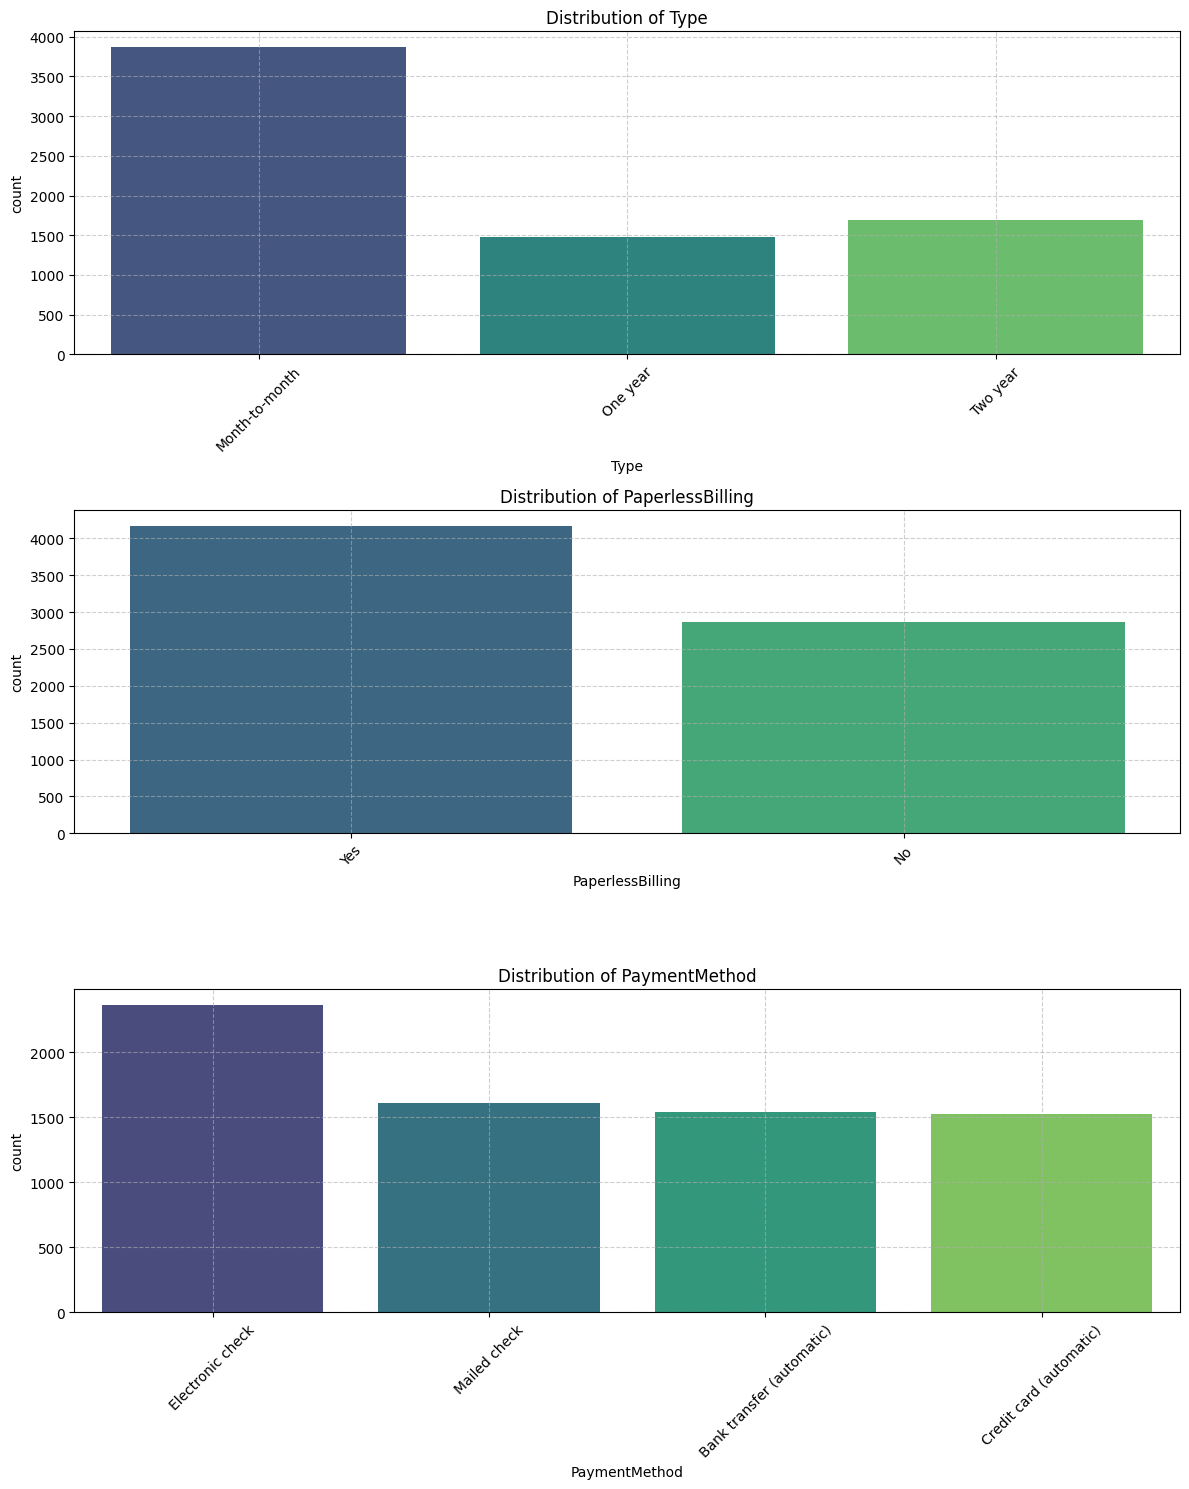

In [25]:
# Построим бар диаграммы для столбцов 'Type' 'PaperlessBilling' 'PaymentMethod'
columns_to_plot = contract_df.columns[3:6]

# Задаем размер графика
plt.figure(figsize=(12, 15))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.countplot(data=contract_df, x=col, hue=col, legend=False, palette="viridis") 
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45) 
    plt.grid(True, linestyle="--", alpha=0.6)

# Вывод графиков
plt.tight_layout()
plt.show()

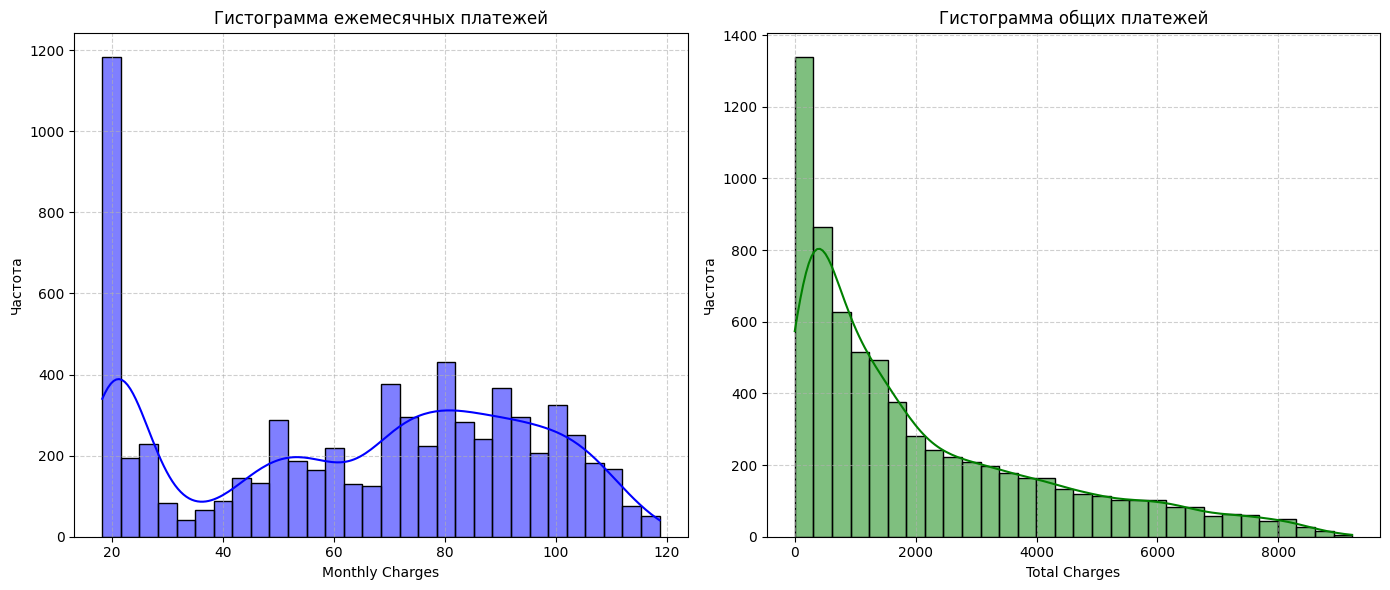

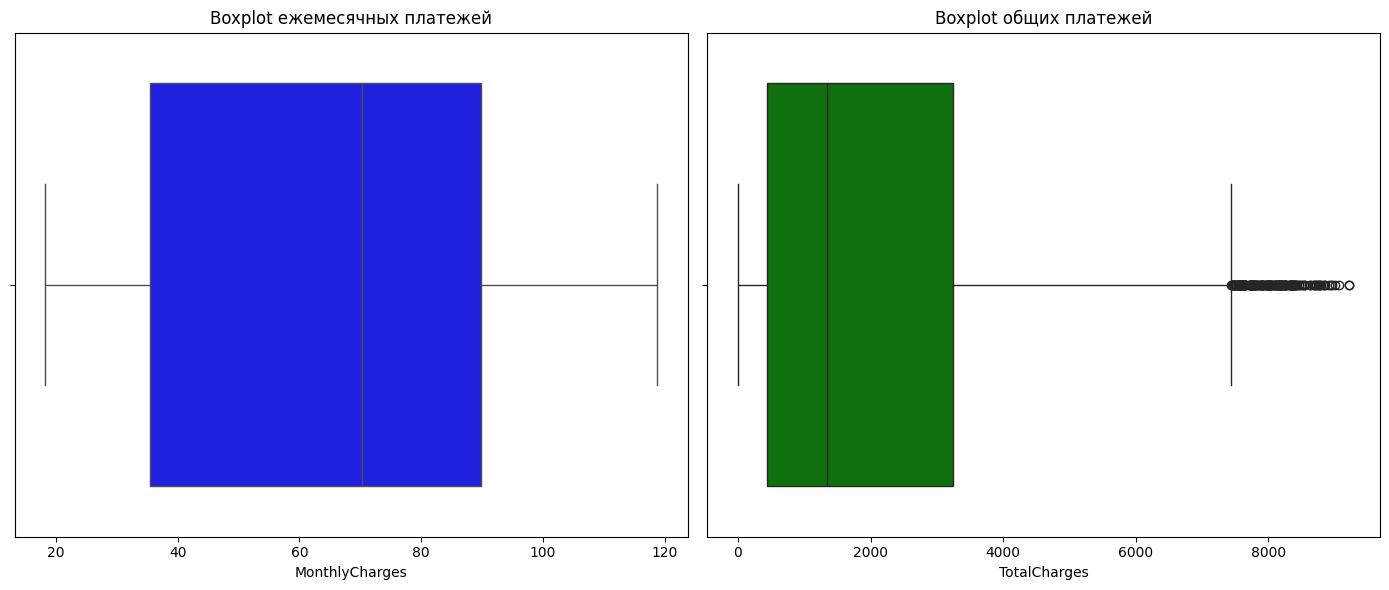

In [26]:
# Построим гистограммы и ящик с усами для столбцов 'MonthlyCharges' 'TotalCharges' 
# Создаем фиг. для гистограмм
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма для 'MonthlyCharges'
sns.histplot(contract_df["MonthlyCharges"], bins=30, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Гистограмма ежемесячных платежей")
axes[0].set_xlabel("Monthly Charges")
axes[0].set_ylabel("Частота")
axes[0].grid(True, linestyle="--", alpha=0.6)

# Гистограмма для 'TotalCharges'
sns.histplot(contract_df["TotalCharges"], bins=30, kde=True, color="green", ax=axes[1])
axes[1].set_title("Гистограмма общих платежей")
axes[1].set_xlabel("Total Charges")
axes[1].set_ylabel("Частота")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Создаем новую фиг. для boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot для 'MonthlyCharges'
sns.boxplot(x=contract_df["MonthlyCharges"], color="blue", ax=axes[0])
axes[0].set_title("Boxplot ежемесячных платежей")

# Boxplot для 'TotalCharges'
sns.boxplot(x=contract_df["TotalCharges"], color="green", ax=axes[1])
axes[1].set_title("Boxplot общих платежей")

plt.tight_layout()
plt.show()

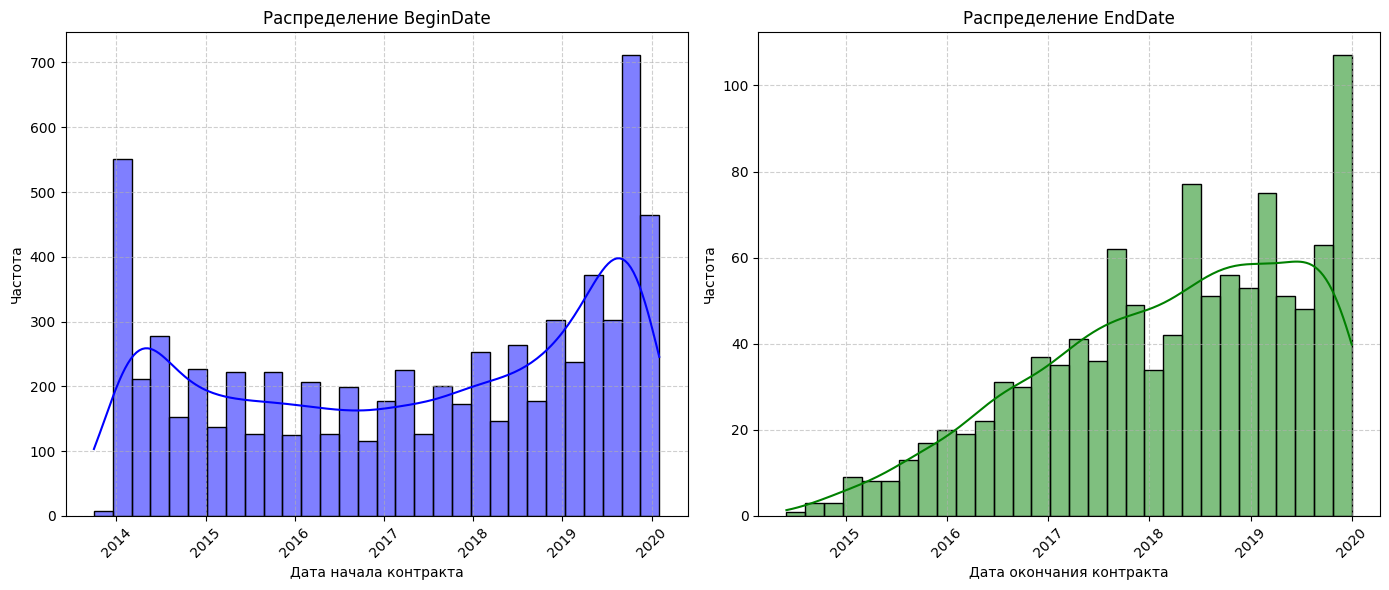

In [27]:
# Построим гистограммы для столбцов с датами "BeginDate" и "EndDate"
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(contract_df["BeginDate"], bins=30, kde=True, color="blue")
plt.title("Распределение BeginDate")
plt.xlabel("Дата начала контракта")
plt.ylabel("Частота")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

plt.subplot(1, 2, 2)
sns.histplot(contract_df["EndDate"], bins=30, kde=True, color="green")
plt.title("Распределение EndDate")
plt.xlabel("Дата окончания контракта")
plt.ylabel("Частота")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

#### Замена отсутствующих данных в "EndDate"

Предположим, что No означает, что контракт еще действует, поэтому для дальнейшей работы заменим No на самую последнюю дату в столбце "EndDate"

In [28]:
# Замена отсутствующих данных в "EndDate"
max_date = contract_df["EndDate"].max()
contract_df["EndDate"] = contract_df["EndDate"].fillna(max_date)

In [29]:
# Преобразуем даты в to_datetime
contract_df["BeginDate"] = pd.to_datetime(contract_df["BeginDate"], errors="coerce")
contract_df["EndDate"] = pd.to_datetime(contract_df["EndDate"], errors="coerce")

# Вычисляем длительность контракта в днях
contract_df["ContractDuration"] = (contract_df["EndDate"] - contract_df["BeginDate"]).dt.days

In [30]:
# Категоризуем длительность контракта 
def categorize_duration(days):
    if days < 180:
        return "Short-term (0-6 months)"
    elif days < 365:
        return "Medium-term (6-12 months)"
    elif days < 730:
        return "Long-term (1-2 years)"
    else:
        return "Very long-term (2+ years)"

contract_df["ContractCategory"] = contract_df["ContractDuration"].apply(categorize_duration)

In [31]:
print(f"Максимальная дата в данных: {max_date}")
contract_df[["BeginDate", "EndDate", "ContractDuration", "ContractCategory"]].head()
print(contract_df["ContractCategory"].value_counts())  

Максимальная дата в данных: 2020-01-01 00:00:00
ContractCategory
Very long-term (2+ years)    3582
Short-term (0-6 months)      1361
Long-term (1-2 years)        1263
Medium-term (6-12 months)     837
Name: count, dtype: int64


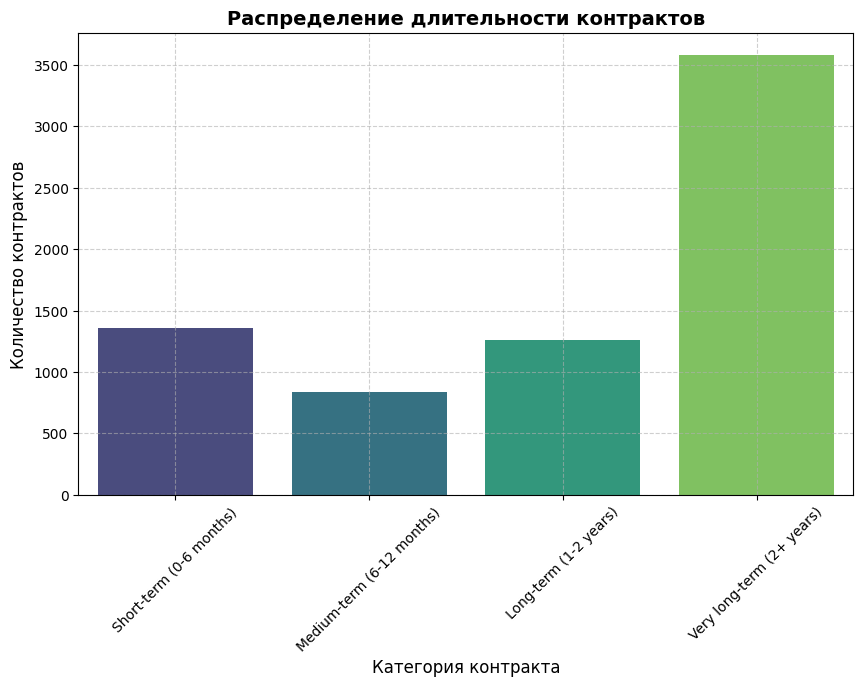

In [32]:
# Определяем порядок категорий
sorted_categories = ["Short-term (0-6 months)", 
                     "Medium-term (6-12 months)", 
                     "Long-term (1-2 years)", 
                     "Very long-term (2+ years)"]
# Указываем порядок категорий в столбце Contract_Category
contract_df["ContractCategory"] = pd.Categorical(
                                    contract_df["ContractCategory"], 
                                    categories=sorted_categories, 
                                    ordered=True)
# Устанавливаем размер фигуры
plt.figure(figsize=(10, 6))

# Создаем бар-диаграмму для категорий контрактов (исправленный код для Seaborn v0.14.0)
sns.countplot(
        data=contract_df, 
        x="ContractCategory", 
        hue="ContractCategory", 
        palette="viridis",
        order=sorted_categories,
        legend=False)

# Настройки заголовка и подписей
plt.title("Распределение длительности контрактов", fontsize=14, fontweight='bold')
plt.xlabel("Категория контракта", fontsize=12)
plt.ylabel("Количество контрактов", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Отображаем график
plt.show()

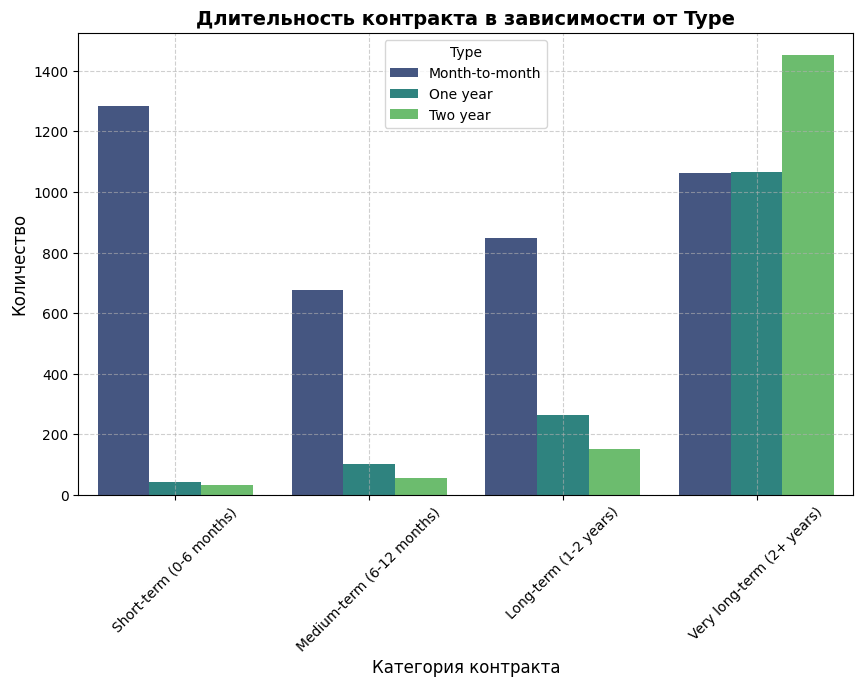

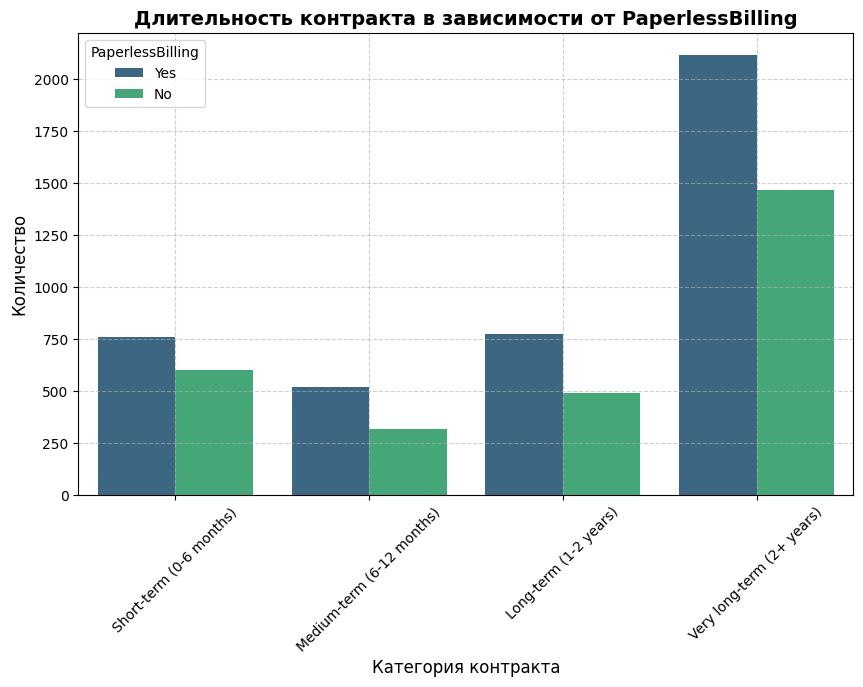

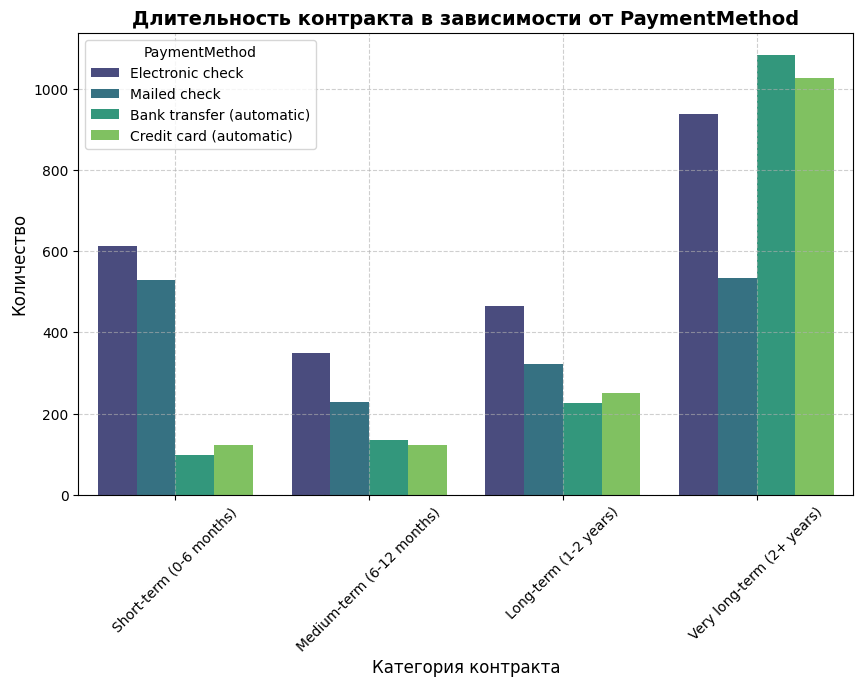

In [33]:
# Фильтрация данных по столбцам
contract_types = ["Type", "PaperlessBilling", "PaymentMethod"]

# Построение отдельных графиков
for contract_type in contract_types:
    plt.figure(figsize=(10, 6))
    sns.countplot(
            data=contract_df, 
            x="ContractCategory", 
            hue=contract_type, 
            palette="viridis", 
            order=sorted_categories)

    # Настройки заголовка и подписей
    plt.title(f"Длительность контракта в зависимости от {contract_type}", fontsize=14, fontweight='bold')
    plt.xlabel("Категория контракта", fontsize=12)
    plt.ylabel("Количество", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=contract_type)  # Добавляем легенду
    plt.grid(True, linestyle="--", alpha=0.6)

    # Отображаем график
    plt.show()

### Выводы

#### Датафрейм personal_df

In [34]:
personal_df.sample(5) 

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
3102,0516-WJVXC,Female,0,No,No
3186,3457-PQBYH,Female,0,Yes,Yes
6583,9617-UDPEU,Female,0,No,No
5390,7450-NWRTR,Male,1,No,No
1339,3838-OZURD,Male,0,Yes,No


In [35]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [36]:
personal_df.shape

(7043, 5)

In [37]:
# Вывод уникальных значений
for column in personal_df.columns[1:]:
    print(f"Уникальные значения в стобце {column}:")
    print(personal_df[column].unique())
    print()

Уникальные значения в стобце Gender:
['Female' 'Male']

Уникальные значения в стобце SeniorCitizen:
['0' '1']

Уникальные значения в стобце Partner:
['Yes' 'No']

Уникальные значения в стобце Dependents:
['No' 'Yes']



In [38]:
personal_df = personal_df.astype({"SeniorCitizen": "int64"})

In [39]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


##### Проверка наличия дубликатов

In [40]:
personal_df.duplicated().sum()

np.int64(0)

In [41]:
personal_df['CustomerID'].duplicated().sum()

np.int64(0)

Дубликаты отсутствуют

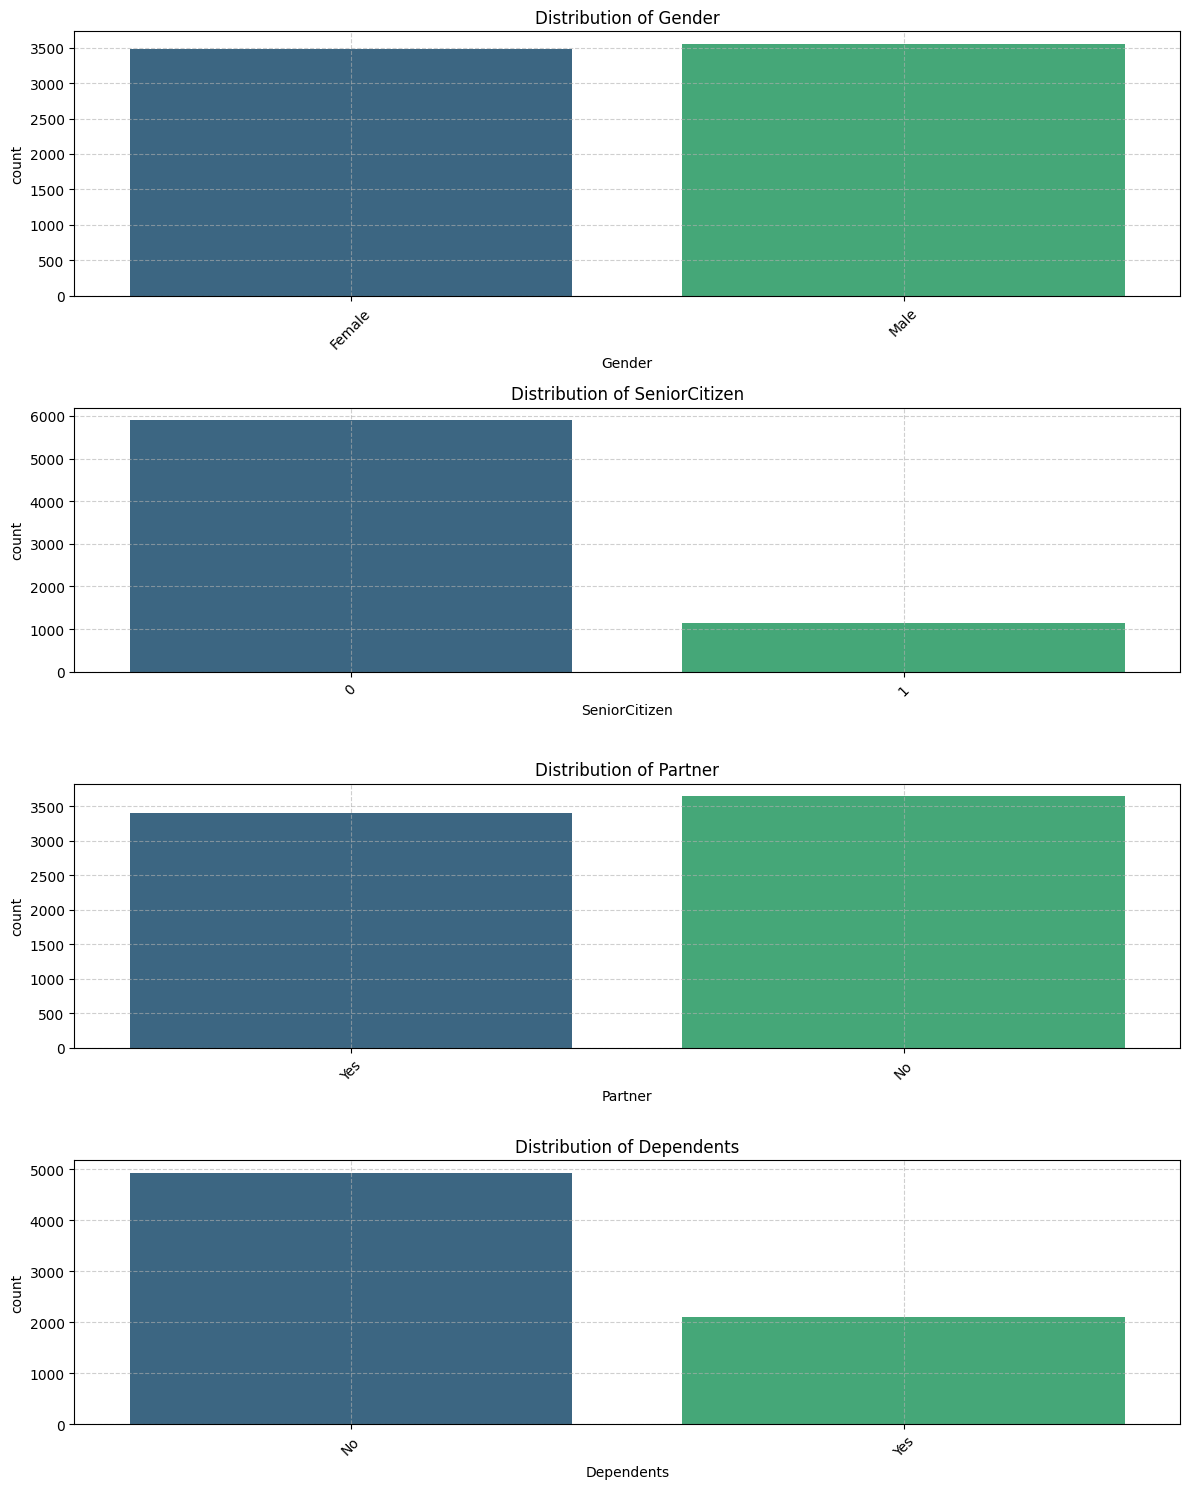

In [42]:
# Построим бар диаграммы для столбцов 'gender', 'SeniorCitizen', 'Partner', 'Dependents'
columns_to_plot = personal_df.columns[1:]

# Задаем размер графика
plt.figure(figsize=(12, 15))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.countplot(data=personal_df, x=col, hue=col, legend=False, palette="viridis") 
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45) 
    plt.grid(True, linestyle="--", alpha=0.6)

# Вывод графиков
plt.tight_layout()
plt.show()

### Выводы

#### Датафрейм phone_df

In [43]:
phone_df.sample(5)

,CustomerID,MultipleLines
6178,7964-ZRKKG,Yes
1145,9992-UJOEL,No
2798,7284-ZZLOH,No
5367,6156-UZDLF,No
2306,0784-ZQJZX,No


In [44]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [45]:
phone_df.shape

(6361, 2)

##### Проверка наличия дубликатов

In [46]:
phone_df['CustomerID'].duplicated().sum()

np.int64(0)

Дубликаты отсутствуют

In [47]:
phone_df['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

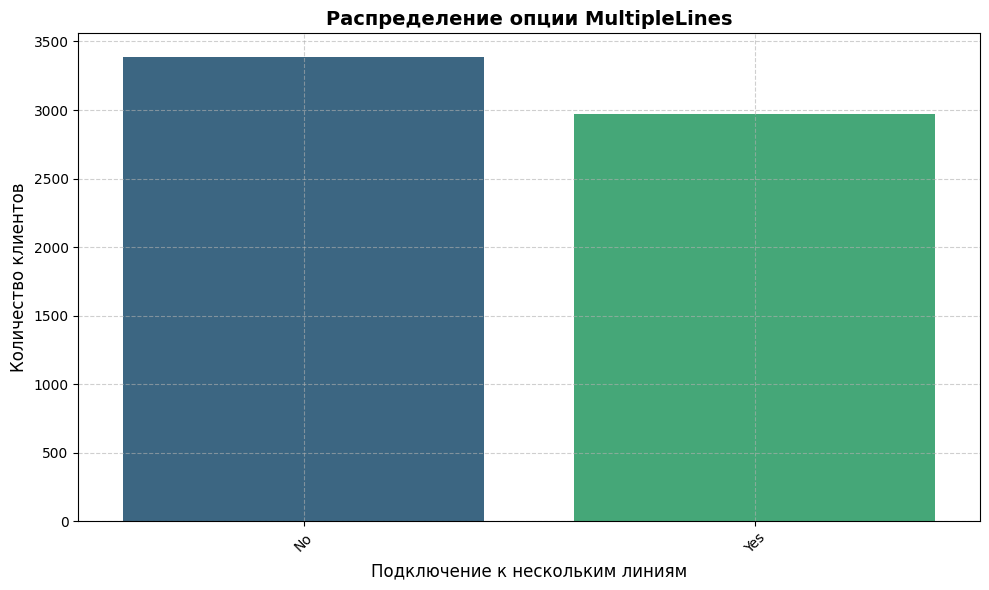

In [48]:
# Построим бар-диаграмму
# Задаем размер графика
plt.figure(figsize=(10, 6))

# Бар-диаграмма для 'MultipleLines' с hue
sns.countplot(data=phone_df, x='MultipleLines', hue='MultipleLines', legend=False, palette="viridis")

# Настройки
plt.title("Распределение опции MultipleLines", fontsize=14, fontweight='bold')
plt.xlabel("Подключение к нескольким линиям", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Отображение графика
plt.tight_layout()
plt.show()

### Выводы

#### Датафрейм internet_df

In [49]:
internet_df.sample(5)

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1251,1205-WNWPJ,DSL,No,No,No,Yes,Yes,No
323,2977-CEBSX,DSL,Yes,Yes,Yes,Yes,Yes,Yes
987,1543-LLLFT,Fiber optic,No,Yes,Yes,Yes,Yes,No
4849,2446-BEGGB,Fiber optic,No,Yes,No,No,Yes,Yes
3394,5792-JALQC,DSL,Yes,No,Yes,No,No,No


In [50]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [51]:
internet_df.shape

(5517, 8)

##### Проверка наличия дубликатов

In [52]:
internet_df.duplicated().sum()

np.int64(0)

In [53]:
internet_df['CustomerID'].duplicated().sum()

np.int64(0)

Дубликаты отсутствуют

In [54]:
# Вывод уникальных значений
for column in internet_df.columns[1:]:
    print(f"Уникальные значения в стобце {column}:")
    print(internet_df[column].unique())
    print()

Уникальные значения в стобце InternetService:
['DSL' 'Fiber optic']

Уникальные значения в стобце OnlineSecurity:
['No' 'Yes']

Уникальные значения в стобце OnlineBackup:
['Yes' 'No']

Уникальные значения в стобце DeviceProtection:
['No' 'Yes']

Уникальные значения в стобце TechSupport:
['No' 'Yes']

Уникальные значения в стобце StreamingTV:
['No' 'Yes']

Уникальные значения в стобце StreamingMovies:
['No' 'Yes']



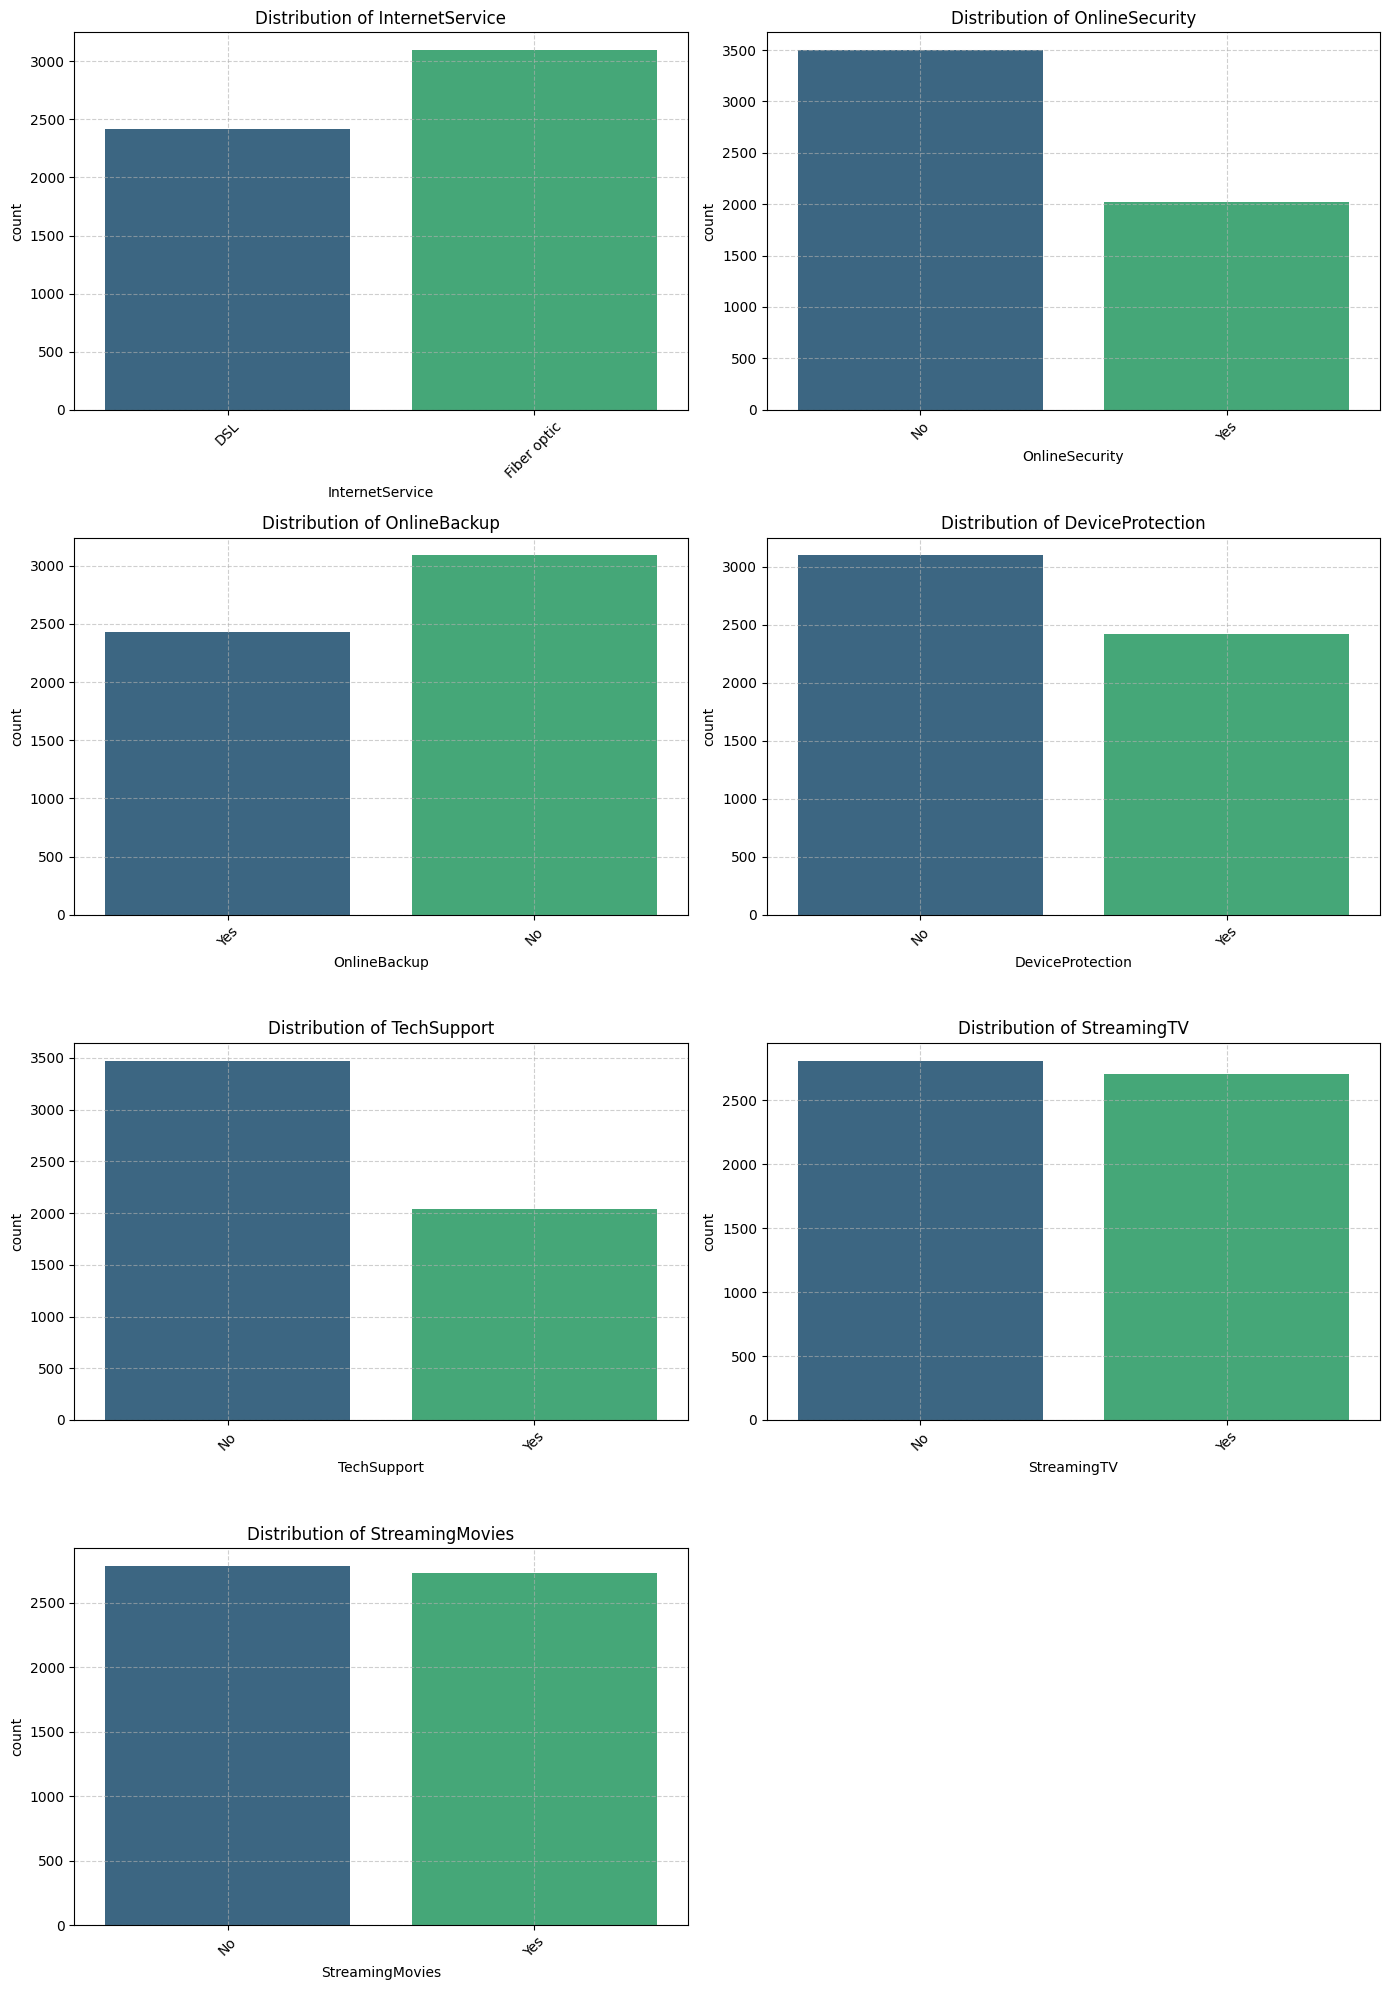

In [55]:
# Построим бар диаграммы
# Определяем столбцы для построения графиков
columns_to_plot = internet_df.columns[1:]  # Исключаем первый столбец (например, ID)
num_cols = len(columns_to_plot)

# Определяем количество строк для 2-х графиков в строке
num_rows = math.ceil(num_cols / 2)

# Создаем фигуру с сеткой 2 столбца на `num_rows` строк
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 5))

# Преобразуем массив осей в одномерный для удобной индексации
axes = axes.flatten()

# Создаем бар-диаграммы
for i, col in enumerate(columns_to_plot):
    sns.countplot(data=internet_df, x=col, hue=col, legend=False, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Удаляем пустые подграфики, если количество столбцов нечетное
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Оптимизация отображения
plt.tight_layout()
plt.show()

### Выводы

### Объединение таблиц по ID клиента

In [56]:
# Объединяем таблицы по 'customerID' (главная таблица - contract_df)
merged_df = contract_df \
    .merge(personal_df, on="CustomerID", how="left") \
    .merge(phone_df, on="CustomerID", how="left") \
    .merge(internet_df, on="CustomerID", how="left")

# Проверяем результат
merged_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,ContractCategory,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Short-term (0-6 months),...,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,2071.84,1005,Very long-term (2+ years),...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2020-01-01,Month-to-month,Yes,Mailed check,53.85,226.17,92,Short-term (0-6 months),...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1960.60,1340,Very long-term (2+ years),...,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2020-01-01,Month-to-month,Yes,Electronic check,70.70,353.50,122,Short-term (0-6 months),...,No,No,No,Fiber optic,No,No,No,No,No,No


In [57]:
merged_df.shape

(7043, 22)

In [58]:
merged_df['CustomerID'].duplicated().sum()

np.int64(0)

In [59]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   ContractDuration  7043 non-null   int64         
 9   ContractCategory  7043 non-null   category      
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  MultipleLines     6361 n

In [60]:
# Проверяем количество пропусков
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Вывод количества пропусков
print("Количество пропусков в каждом признаке:")
print(missing_values)

Количество пропусков в каждом признаке:
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64


In [61]:
# Определяем максимальную дату в столбце EndDate (последняя зафиксированная дата в данных)
max_end_date = merged_df["EndDate"].max()

# Создаем признак "ушел или нет" (1 - ушел, 0 - остался)
merged_df["Churn"] = np.where(merged_df["EndDate"] < max_end_date, 1, 0)

# Вычисляем количество дней от конца контракта до максимальной даты (для ушедших клиентов)
merged_df["DaysSinceEnd"] = np.where(
    merged_df["Churn"] == 1,
    (max_end_date - merged_df["EndDate"]).dt.days,
    0  # Для активных клиентов ставим 0
)

# Проверяем результат
merged_df.sample(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,ContractCategory,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,DaysSinceEnd
5630,9801-GDWGV,2016-10-01,2017-12-01,Month-to-month,Yes,Electronic check,103.45,1506.23,426,Long-term (1-2 years),...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,1,761
260,7273-TEFQD,2019-08-01,2020-01-01,Month-to-month,Yes,Electronic check,41.15,246.90,153,Short-term (0-6 months),...,NaN,DSL,No,No,Yes,No,No,Yes,0,0
5763,9633-XQABV,2019-11-01,2020-01-01,Month-to-month,Yes,Electronic check,70.25,225.50,61,Short-term (0-6 months),...,No,Fiber optic,No,No,No,No,No,No,0,0
5484,4419-UJMUS,2014-05-01,2020-01-01,Two year,Yes,Electronic check,99.35,6992.25,2071,Very long-term (2+ years),...,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,0,0
2539,2050-ONYDQ,2014-09-01,2020-01-01,Two year,No,Credit card (automatic),26.00,1690.00,1948,Very long-term (2+ years),...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   ContractDuration  7043 non-null   int64         
 9   ContractCategory  7043 non-null   category      
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  MultipleLines     6361 n

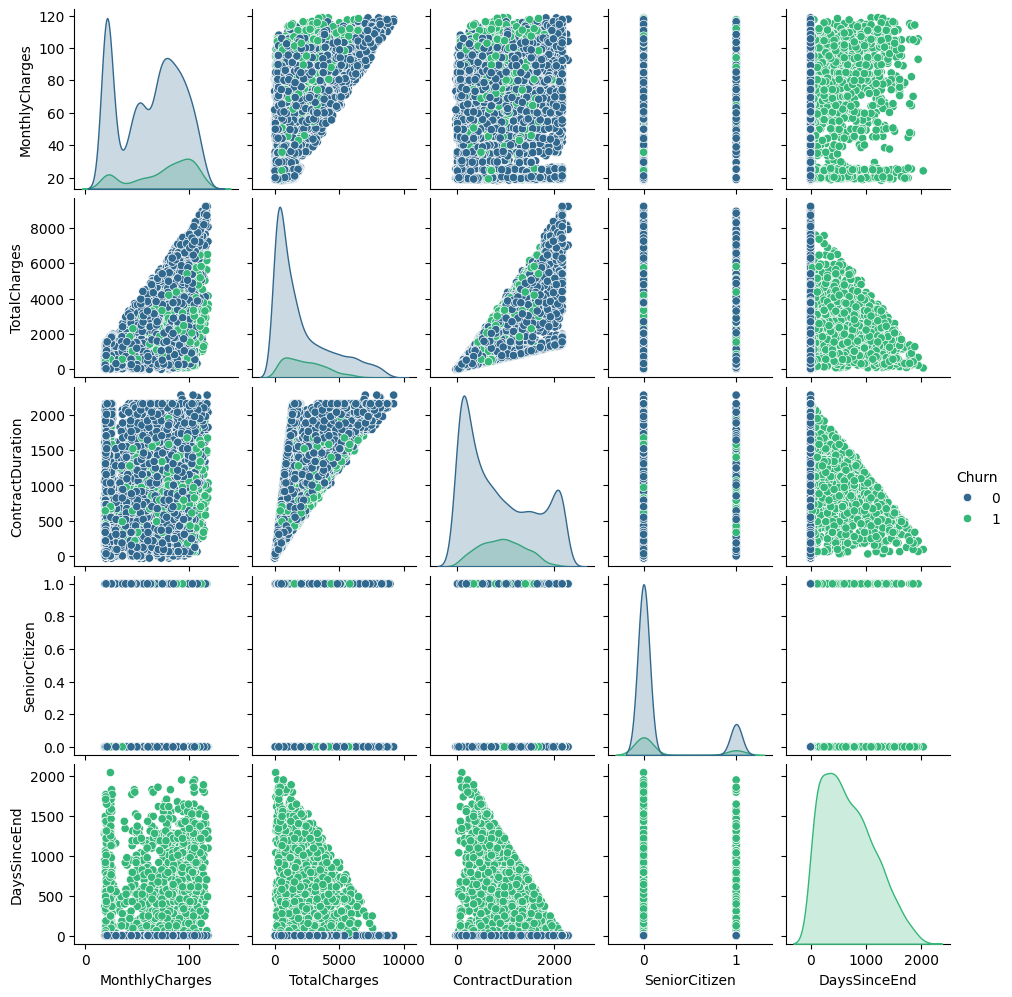

In [65]:
# Выбираем числовые признаки для анализа
selected_columns = ["MonthlyCharges", "TotalCharges", "ContractDuration",
                    "SeniorCitizen", "DaysSinceEnd", "Churn"]

# Построение pairplot с hue по `Сhurn`
sns.pairplot(data=merged_df[selected_columns], hue="Churn", palette="viridis")

# Устанавливаем размер графика
plt.gcf().set_size_inches(10, 10)
plt.show()

In [73]:
# Определяем интервальные признаки (исключаем CustomerID)
interval_cols = merged_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
if "CustomerID" in interval_cols:
    interval_cols.remove("CustomerID")

In [75]:
# Вычисляем phi_K корреляцию (без CustomerID)
phik_overview = merged_df.drop(columns=["CustomerID"]).phik_matrix(interval_cols=interval_cols)

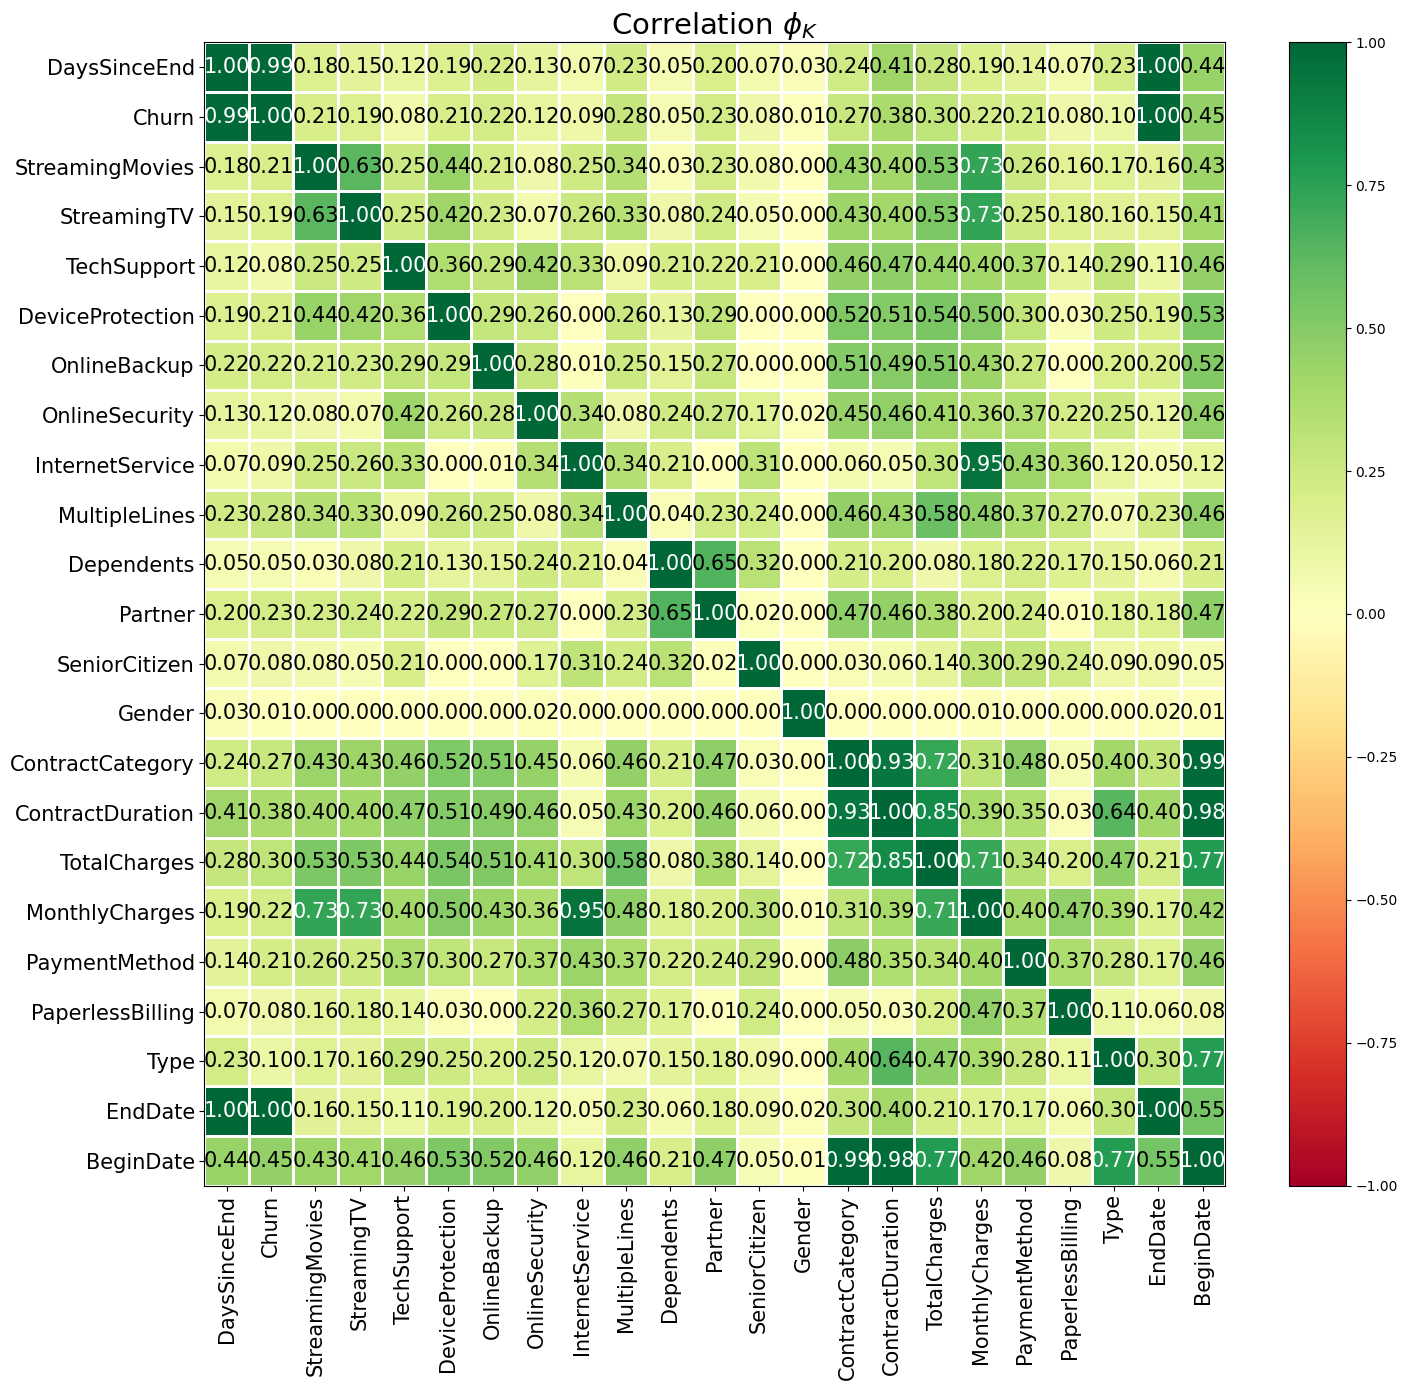

In [76]:
# Визуализация тепловой карты коэффициентов phi_K
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 14)
)

### Выводы

### Подготовка данные для обучения